In [1]:
if 'google.colab' in str(get_ipython()):
  !pip install PyCO2SYS

In [2]:
from itertools import product
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import PyCO2SYS as csys

import glodap

## Load the GLODAP dataset 

[GLODAP](https://www.glodap.info/) is a observational synthesis of biogeochemical variables over the global ocean.

The `glodap` module provides an interface to these data.

In [3]:
ds = glodap.open_glodap(product='GLODAPv2.2016b_MappedClimatologies')

# subset for surface
ds = ds.isel(depth=0, drop=True)
ds

<xarray.Dataset> Size: 8MB
Dimensions:       (lat: 180, lon: 360, bnds: 2)
Coordinates:
  * lon           (lon) float64 3kB 20.5 21.5 22.5 23.5 ... 377.5 378.5 379.5
  * lat           (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Dimensions without coordinates: bnds
Data variables: (12/17)
    Cant          (lat, lon) float64 518kB ...
    NO3           (lat, lon) float64 518kB ...
    OmegaA        (lat, lon) float64 518kB ...
    OmegaC        (lat, lon) float64 518kB ...
    PI_TCO2       (lat, lon) float64 518kB ...
    PO4           (lat, lon) float64 518kB ...
    ...            ...
    SALT          (lat, lon) float64 518kB ...
    SiO3          (lat, lon) float64 518kB ...
    TEMP          (lat, lon) float64 518kB ...
    area          (lat, lon) float64 518kB 1.079e+08 1.079e+08 ... 1.079e+08
    depth_bnds    (bnds) float64 16B -5.0 5.0
    dz            float64 8B 10.0
Attributes:
    Description:          1 X 1 global mapped field of anthropogenic carbon c...
    Created:              Created by Siv K. Lauvset on 12-May-2016 18:48:16
    Institution name:     University of Bergen
    Contact information:  siv.lauvset@uib.no; are.olsen@uib.no
    Citation:             Cite as: Lauvset, Siv K., Key, Robert M., Olsen, Ar...

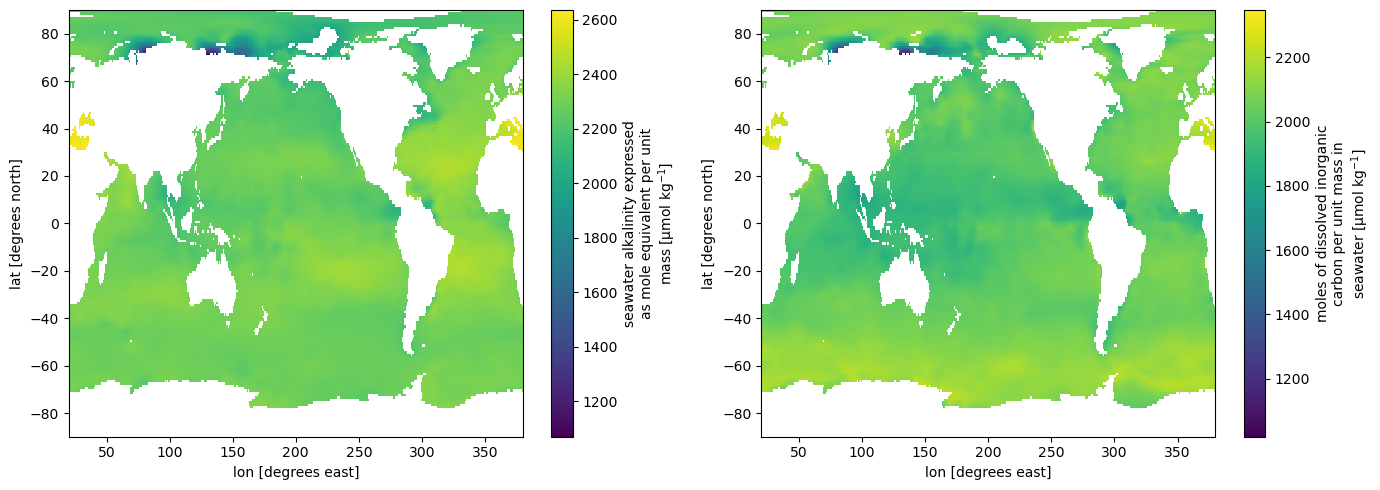

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

ds.ALK.plot(ax=axs[0]);
ds.DIC.plot(ax=axs[1]);
plt.tight_layout();

## Background state information

In [5]:
lon = 200
lat = 35

ds_point = ds.sel(lon=lon, lat=lat, method='nearest')
ocn_state = {
    k: np.round(ds_point[k].values.item(0), 2)
    for k in ['TEMP', 'SALT', 'ALK', 'DIC', 'PO4', 'SiO3']
}
ocn_state

{'TEMP': 24.37,
 'SALT': 34.51,
 'ALK': 2261.89,
 'DIC': 1986.98,
 'PO4': 0.12,
 'SiO3': 4.23}

Get some guidance on a sensible range for varying alkalinty

In [9]:
alk_bounds = np.nanpercentile(ds.ALK, [5, 95])
alk_bounds

array([2162.93731689, 2395.07904053])

Set up [PyCO2SYS](https://pyco2sys.readthedocs.io)

In [28]:
# CO2SYS parameter types
par_type = dict(alk=1, dic=2, pH=3, pCO2=4)

def csys_renamer(result):
    mapper = {
        'saturation_calcite': 'omega_calc',
        'saturation_aragonite': 'omega_arag',
        'alkalinity': 'alk',
    }
    for k_old, k_new in mapper.items():
        result[k_new] = result.pop(k_old)
    return result


# precompute equilibrium constants (for performance)
result = csys.sys(
      temperature=ocn_state['TEMP'],
      salinity=ocn_state['SALT'],
      )
equil_constants = {k: v for k, v in result.items() if k[:2] == 'k_'}

## CO2 Slider

Figure: CO2 slider: slide atmospheric CO2, show concentrations of CO2, HCO3, and CO3 species, total DIC, pH and Ω

In [31]:
alk = ocn_state['ALK'] # µmol/kg

# conditions that vary
index_keys = ['pCO2']
pco2_range = np.arange(280.0, 560.0, 10.)

# results to save in the table
result_keys = [
    'dic', 'alk', 'CO2', 'HCO3', 'CO3', 'pH',
    'omega_calc', 'omega_arag',
]

# compute the lookup table
rows = []
for pco2 in pco2_range:
    result = csys.sys(
        par1=pco2,
        par2=alk,
        par1_type=par_type['pCO2'],
        par2_type=par_type['alk'],
        temperature=ocn_state['TEMP'],
        salinity=ocn_state['SALT'],
        total_silicate=ocn_state['SiO3'],
        total_phosphate=ocn_state['PO4'],
        **equil_constants,
    )
    result = csys_renamer(result)
    rows.append({k: result[k] for k in result_keys + index_keys})

df = pd.DataFrame(rows).set_index(keys=index_keys)
df

,dic,alk,CO2,HCO3,CO3,pH,omega_calc,omega_arag
pCO2,,,,,,,,
280.0,1902.763418,2261.89,8.072635,1644.457000,250.233782,8.163236,6.041785,3.971491
290.0,1910.446708,2261.89,8.360944,1656.831043,245.254721,8.151251,5.921568,3.892468
300.0,1917.816492,2261.89,8.649252,1668.683544,240.483697,8.139624,5.806374,3.816746
310.0,1924.893568,2261.89,8.937560,1680.048878,235.907130,8.128331,5.695875,3.744111
320.0,1931.696834,2261.89,9.225869,1690.958304,231.512661,8.117354,5.589772,3.674366
330.0,1938.243513,2261.89,9.514177,1701.440328,227.289008,8.106674,5.487794,3.607332
340.0,1944.549338,2261.89,9.802486,1711.521006,223.225846,8.096274,5.389690,3.542845
350.0,1950.628721,2261.89,10.090794,1721.224218,219.313709,8.086141,5.295234,3.480755
360.0,1956.494891,2261.89,10.379102,1730.571897,215.543892,8.076258,5.204213,3.420924


## Alkalinity slider

Figure: Alkalinity slider: slide alkalinity amount, show concentrations of CO2, HCO3, and CO3 species and total DIC, pH and Ω

In [41]:
index_keys = ['alk_initial', 'dic_initial']

# set range for DIC and ALK based on percentile values of 
# global surface ocean
alk_initial_range = np.nanpercentile(ds.ALK, [5, 50, 95]) #np.arange(5, 100, 5))
dic_initial_range = np.nanpercentile(ds.DIC, [5, 50, 95]) #np.arange(5, 100, 5))

# set a range of alkalinity additions
alk_add_range = np.arange(0, 1100, 100)


# results to save in the table
result_keys = [
    'dic', 'pCO2', 'CO2', 'HCO3', 'CO3', 'pH',
    'omega_calc', 'omega_arag',
]


# compute the lookup table
rows = []
for dic_initial, alk_initial in product(dic_initial_range, alk_initial_range):
    # compute pCO2_initial
    result = csys.sys(
        par1=dic_initial,
        par2=alk_initial,
        par1_type=par_type['dic'],
        par2_type=par_type['alk'],
        temperature=ocn_state['TEMP'],
        salinity=ocn_state['SALT'],
        total_silicate=ocn_state['SiO3'],
        total_phosphate=ocn_state['PO4'],
        **equil_constants,
    )
    pCO2_initial = result['pCO2']

    for alk_add in alk_add_range:
        # compute pre-equilibrated result
        result = csys.sys(
            par1=dic_initial,
            par2=alk_initial + alk_add,
            par1_type=par_type['dic'],
            par2_type=par_type['alk'],
            temperature=ocn_state['TEMP'],
            salinity=ocn_state['SALT'],
            total_silicate=ocn_state['SiO3'],
            total_phosphate=ocn_state['PO4'],
            **equil_constants,
        )
        result = csys_renamer(result)

        row_data = dict(
            alk_initial=alk_initial,
            dic_initial=dic_initial,
            pCO2_initial=pCO2_initial,
            alk=alk_initial + alk_add
        )
        row_data.update({k + '_pre': result[k] for k in result_keys})

        # compute equilibrated result
        result = csys.sys(
            par1=pCO2_initial,
            par2=alk_initial + alk_add,
            par1_type=par_type['pCO2'],
            par2_type=par_type['alk'],
            temperature=ocn_state['TEMP'],
            salinity=ocn_state['SALT'],
            total_silicate=ocn_state['SiO3'],
            total_phosphate=ocn_state['PO4'],
            **equil_constants,
        )
        result = csys_renamer(result)

        row_data.update({k + '_equil': result[k] for k in result_keys})

        # confirm expectations
        np.testing.assert_almost_equal(row_data['pCO2_initial'], row_data['pCO2_equil'], decimal=7)
        np.testing.assert_almost_equal(row_data['dic_initial'], row_data['dic_pre'], decimal=7)

        rows.append(row_data)

df = pd.DataFrame(rows).set_index(keys=index_keys)
df

pCO2_initial          alk      dic_pre    pCO2_pre  \
alk_initial dic_initial                                                       
2162.937317 1901.024304    408.851892  2162.937317  1901.024304  408.851892   
            1901.024304    408.851892  2262.937317  1901.024304  276.760861   
            1901.024304    408.851892  2362.937317  1901.024304  198.817120   
            1901.024304    408.851892  2462.937317  1901.024304  148.197632   
            1901.024304    408.851892  2562.937317  1901.024304  113.131057   
...                               ...          ...          ...         ...   
2395.079041 2157.200879    564.399154  2995.079041  2157.200879   98.830145   
            2157.200879    564.399154  3095.079041  2157.200879   79.163209   
            2157.200879    564.399154  3195.079041  2157.200879   63.729342   
            2157.200879    564.399154  3295.079041  2157.200879   51.432744   
            2157.200879    564.399154  3395.079041  2157.200879   41.524225   

                           CO2_pre     HCO3_pre     CO3_pre    pH_pre  \
alk_initial dic_initial                                                 
2162.937317 1901.024304  11.787543  1705.012072  184.224689  8.014533   
            1901.024304   7.979248  1640.958604  252.086452  8.167364   
            1901.024304   5.732065  1572.887998  322.404241  8.292615   
            1901.024304   4.272662  1502.218272  394.533370  8.400263   
            1901.024304   3.261663  1429.659006  468.103635  8.496022   
...                            ...          ...         ...       ...   
2395.079041 2157.200879   2.849356  1535.908115  618.443407  8.585847   
            2157.200879   2.282342  1458.600000  696.318538  8.659784   
            2157.200879   1.837370  1380.527649  774.835859  8.730077   
            2157.200879   1.482849  1301.892204  853.825826  8.797706   
            2157.200879   1.197178  1222.892033  933.111668  8.863458   

                         omega_calc_pre  omega_arag_pre    dic_equil  \
alk_initial dic_initial                                                
2162.937317 1901.024304        4.448025        2.923853  1901.024304   
            1901.024304        6.086517        4.000895  1983.320229   
            1901.024304        7.784309        5.116918  2065.283388   
            1901.024304        9.525836        6.261688  2146.923707   
            1901.024304       11.302158        7.429331  2228.250631   
...                                 ...             ...          ...   
2395.079041 2157.200879       14.932046        9.815392  2660.231859   
            2157.200879       16.812307       11.051358  2743.112958   
            2157.200879       18.708073       12.297516  2825.737585   
            2157.200879       20.615251       13.551175  2908.111597   
            2157.200879       22.529573       14.809531  2990.240629   

                         pCO2_equil  CO2_equil   HCO3_equil   CO3_equil  \
alk_initial dic_initial                                                   
2162.937317 1901.024304  408.851892  11.787543  1705.012072  184.224689   
            1901.024304  408.851892  11.787543  1772.447226  199.085459   
            1901.024304  408.851892  11.787543  1839.145137  214.350708   
            1901.024304  408.851892  11.787543  1905.128860  230.007304   
            1901.024304  408.851892  11.787543  1970.420290  246.042798   
...                             ...        ...          ...         ...   
2395.079041 2157.200879  564.399154  16.272102  2383.223160  260.736598   
            2157.200879  564.399154  16.272102  2451.051528  275.789328   
            2157.200879  564.399154  16.272102  2518.328524  291.136960   
            2157.200879  564.399154  16.272102  2585.067136  306.772359   
            2157.200879  564.399154  16.272102  2651.279857  322.688671   

                         pH_equil  omega_calc_equil  omega_arag_equil  
alk_initial dic_initial                                       